<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-pandas,-matplotlib,-and-the-StandardScaler-and-IsolationForest-modules-from-scikit-learn" data-toc-modified-id="Load-pandas,-matplotlib,-and-the-StandardScaler-and-IsolationForest-modules-from-scikit-learn-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load pandas, matplotlib, and the StandardScaler and IsolationForest modules from scikit-learn</a></span></li><li><span><a href="#Create-a-standardized-analysis-data-frame" data-toc-modified-id="Create-a-standardized-analysis-data-frame-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create a standardized analysis data frame</a></span></li><li><span><a href="#Run-an-Isolation-Forest-model-to-detect-outliers" data-toc-modified-id="Run-an-Isolation-Forest-model-to-detect-outliers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Run an Isolation Forest model to detect outliers</a></span></li><li><span><a href="#Create-outlier-and-inlier-data-frames" data-toc-modified-id="Create-outlier-and-inlier-data-frames-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create outlier and inlier data frames</a></span></li><li><span><a href="#Plot-the-outliers-and-inliers" data-toc-modified-id="Plot-the-outliers-and-inliers-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot the outliers and inliers</a></span></li></ul></div>

# Load pandas, matplotlib, and the StandardScaler and IsolationForest modules from scikit-learn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# pd.set_option('display.width', 80)
# pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_columns', 7)

In [4]:
import watermark
%load_ext watermark

%watermark -n -v -iv

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.20.0

json      : 2.0.9
pandas    : 1.2.1
matplotlib: 3.3.2
watermark : 2.1.0



In [5]:
covidtotals = pd.read_csv('data/covidtotals.csv')
covidtotals.set_index('iso_code', inplace=True)

# Create a standardized analysis data frame

In [6]:
analysisvars = [
    'location', 'total_cases_pm', 'total_deaths_pm', 'pop_density',
    'median_age', 'gdp_per_capita'
]

In [7]:
standardizer = StandardScaler()

In [8]:
covidtotals.isnull().sum()

lastdate            0
location            0
total_cases         0
total_deaths        0
total_cases_pm      0
total_deaths_pm     0
population          0
pop_density        12
median_age         24
gdp_per_capita     28
hosp_beds          46
dtype: int64

In [9]:
covidanalysis = covidtotals.loc[:, analysisvars].dropna()

In [10]:
covidanalysisstand = standardizer.fit_transform(covidanalysis.iloc[:, 1:])

# Run an Isolation Forest model to detect outliers

In [11]:
clf = IsolationForest(n_estimators=100,
                      max_samples='auto',
                      contamination=0.1,
                      max_features=1.0)

In [12]:
clf.fit(covidanalysisstand)

IsolationForest(contamination=0.1)

In [13]:
covidanalysis['anomaly'] = clf.predict(covidanalysisstand)

In [14]:
covidanalysis['scores'] = clf.decision_function(covidanalysisstand)

In [15]:
covidanalysis['anomaly'].value_counts()

 1    157
-1     18
Name: anomaly, dtype: int64

# Create outlier and inlier data frames

In [17]:
inlier, outlier = covidanalysis.loc[
    covidanalysis['anomaly'] == 1], covidanalysis.loc[covidanalysis['anomaly']
                                                      == -1]

In [19]:
outlier.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, BHR to USA
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   location         18 non-null     object 
 1   total_cases_pm   18 non-null     float64
 2   total_deaths_pm  18 non-null     float64
 3   pop_density      18 non-null     float64
 4   median_age       18 non-null     float64
 5   gdp_per_capita   18 non-null     float64
 6   anomaly          18 non-null     int32  
 7   scores           18 non-null     float64
dtypes: float64(6), int32(1), object(1)
memory usage: 1.2+ KB


In [18]:
outlier[[
    'location', 'total_cases_pm', 'total_deaths_pm', 'median_age',
    'gdp_per_capita', 'scores'
]].sort_values(['scores']).head(10)

,location,total_cases_pm,total_deaths_pm,median_age,gdp_per_capita,scores
iso_code,,,,,,
SGP,Singapore,5962.727,3.931,42.4,85535.383,-0.220213
QAT,Qatar,19753.146,13.190,31.9,116935.600,-0.218644
HKG,Hong Kong,0.000,0.000,44.8,56054.920,-0.157571
BEL,Belgium,5037.354,816.852,41.8,42658.576,-0.133513
LUX,Luxembourg,6418.776,175.726,39.7,94277.965,-0.108238
ITA,Italy,3853.985,552.663,47.9,35220.084,-0.096922
BHR,Bahrain,6698.468,11.166,32.4,43290.705,-0.095249
ESP,Spain,5120.952,580.197,45.5,34272.360,-0.080078
GBR,United Kingdom,4047.403,566.965,40.8,39753.244,-0.049598


# Plot the outliers and inliers

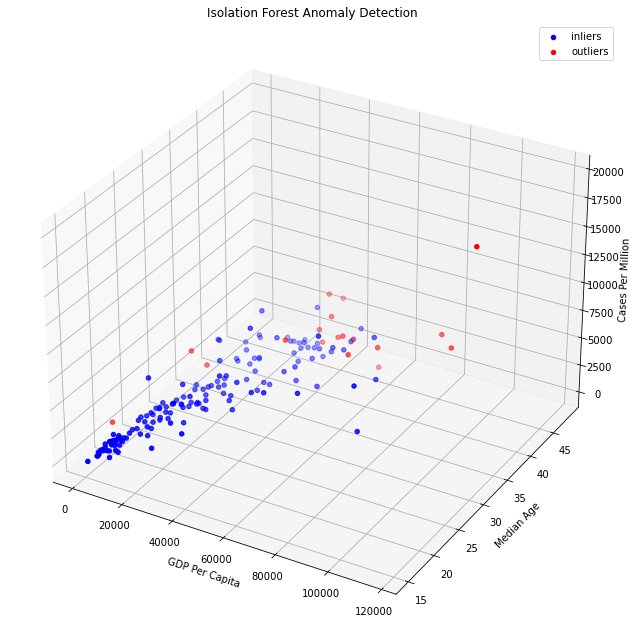

In [22]:
ax = plt.subplots(figsize=(12, 9))
ax = plt.axes(projection='3d')
ax.set_title('Isolation Forest Anomaly Detection')
ax.set_zlabel('Cases Per Million')
ax.set_xlabel('GDP Per Capita')
ax.set_ylabel('Median Age')
ax.scatter3D(inlier['gdp_per_capita'],
             inlier['median_age'],
             inlier['total_cases_pm'],
             label='inliers',
             c='blue')
ax.scatter3D(outlier['gdp_per_capita'],
             outlier['median_age'],
             outlier['total_cases_pm'],
             label='outliers',
             c='red')
ax.legend()
plt.tight_layout()
plt.show()